#### Ribo-Seq validation

In this notebook we use data from published ribosome profiling studies to derive another measure of ribosome loading and we check to what extent our model can predict it from sequence

In [ ]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from keras.models import load_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

pd.options.mode.chained_assignment = None 

### Importing the data and model

In [2]:
with open("../Data/ribo_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)
    
andreev_df = data_dict["andreev"]
pcr3_df = data_dict["pcr3"]

In [87]:
new_model = load_model("../Models/basic_model_scaled.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

### Prepare the data

In [80]:
## Subsetting
andreev_df_sub = andreev_df[(andreev_df["rpf"] > 10) & (andreev_df["rnaseq_norm"] > 100)]
pcr3_df_sub = pcr3_df[(pcr3_df["control1(RPF)_normalized"] > 10) & (pcr3_df["control1(mRNA)_normalized"] > 100)]

In [81]:
## Computing the load
andreev_df_sub["log_load"] = np.log(andreev_df_sub["rpf"]/andreev_df_sub["rnaseq_norm"])
pcr3_df_sub["log_load_control_1"] = np.log(pcr3_df_sub["control1(RPF)_normalized"]/pcr3_df_sub["control1(mRNA)_normalized"])
pcr3_df_sub["log_load_control_2"] = np.log(pcr3_df_sub["control2(RPF)_normalized"]/pcr3_df_sub["control2(mRNA)_normalized"])

In [82]:
## Encoding the sequences
andreev_df_sub["library"] = "egfp_unmod_1"
andreev_encoded = utils.encode_df(andreev_df_sub, col="utr", output_col=None, variable_len=True)

pcr3_df_sub["library"] = "egfp_unmod_1"
pcr3_encoded = utils.encode_df(pcr3_df_sub, col="utr", output_col=None, variable_len=True)

### Predict

In [89]:
predictions_andreev = new_model.predict([andreev_encoded["seq"], andreev_encoded["library"]])
predictions_pcr3 = new_model.predict([pcr3_encoded["seq"], pcr3_encoded["library"]])

### Evaluate

In [90]:
utils.pearson_r(predictions_andreev.reshape(-1), andreev_df_sub["log_load"])[0]

0.05269553800937171

In [91]:
utils.pearson_r(predictions_pcr3.reshape(-1), pcr3_df_sub["log_load_control_1"])[0]

0.06365050268819944

In [92]:
utils.pearson_r(predictions_pcr3.reshape(-1), pcr3_df_sub["log_load_control_2"])[0]

0.0573597589917672

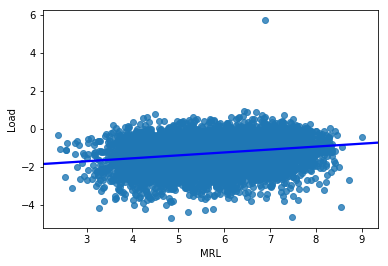

In [93]:
df = pd.DataFrame({"MRL":predictions_andreev.reshape(-1), "Load":andreev_df_sub["log_load"]})
x = sns.regplot(x='MRL', y="Load", data=df, line_kws={"color":"b"}).get_figure()

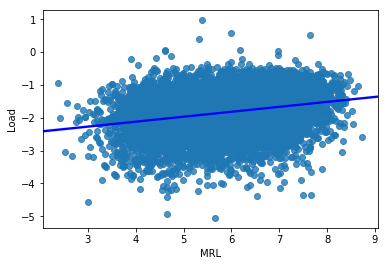

In [94]:
df = pd.DataFrame({"MRL":predictions_pcr3.reshape(-1), "Load":pcr3_df_sub["log_load_control_1"]})
x = sns.regplot(x='MRL', y="Load", data=df, line_kws={"color":"b"}).get_figure()

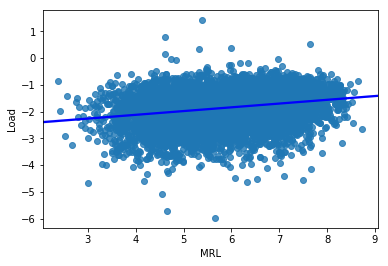

In [95]:
df = pd.DataFrame({"MRL":predictions_pcr3.reshape(-1), "Load":pcr3_df_sub["log_load_control_2"]})
x = sns.regplot(x='MRL', y="Load", data=df, line_kws={"color":"b"}).get_figure()

In each case the pearson r-squared hovers around 5%. This shows that the model does capture some notion of translation efficiency. It should be noted that the model only looks at the 5utr. While this contributes to ribosome load, the load as measured in an ribo-seq experiment will be heavily impacted by such factors as codon-efficiency, overall gene length and also the 3utr.

### Compute r-squared for baseline fixed length model

In [96]:
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5")

In [97]:
andreev_df_sub_50 = andreev_df_sub.copy()
andreev_df_sub_50["utr"] = andreev_df_sub["utr"].str[-50:]
andreev_encoded_sub_50 = utils.encode_df(andreev_df_sub_50, col="utr", output_col=None, variable_len=True)

pcr3_df_sub_50 = pcr3_df_sub.copy()
pcr3_df_sub_50["utr"] = pcr3_df_sub["utr"].str[-50:]
pcr3_encoded_sub_50 = utils.encode_df(pcr3_df_sub_50, col="utr", output_col=None, variable_len=True)

In [98]:
predictions_andreev = paper_model.predict(andreev_encoded_sub_50["seq"])
predictions_pcr3 = paper_model.predict(pcr3_encoded_sub_50["seq"])

In [99]:
print(utils.pearson_r(predictions_andreev.reshape(-1), andreev_df_sub["log_load"])[0])
print(utils.pearson_r(predictions_pcr3.reshape(-1), pcr3_df_sub["log_load_control_1"])[0])
print(utils.pearson_r(predictions_pcr3.reshape(-1), pcr3_df_sub["log_load_control_2"])[0])

0.02729847341406566
0.05236026424223495
0.04732865715659323


While the fixed-size model still does remarkably well, it clearly performs worse than its size flexible counterpart (which is unsurprising, given that it will miss any motive more than 50 nucleotides from the canonical start)